# k-means法

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

## k-means法の基礎

In [7]:
from sklearn.datasets.samples_generator import make_blobs

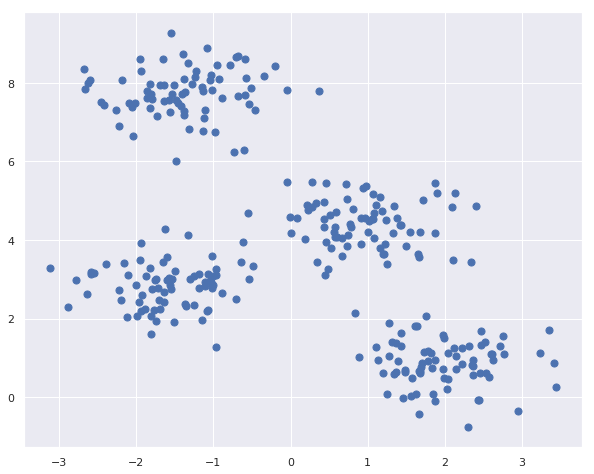

In [10]:
X, y_true = make_blobs(n_samples=300, centers=4,
                                          cluster_std=0.6, random_state=0)
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], s=50)

In [11]:
from sklearn.cluster import KMeans

In [14]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

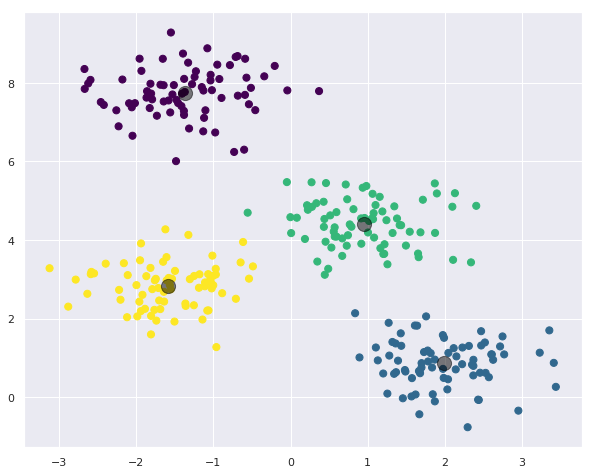

In [18]:
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers =kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

## 期待値最大化法

In [24]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # ランダムにクラスタを選択
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 最近傍のクラスタでラベル付けをする
        labels = pairwise_distances_argmin(X, centers)
        
        # ポイントの平均lからクラスタの中心を決定する
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 収束しているか調べる
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

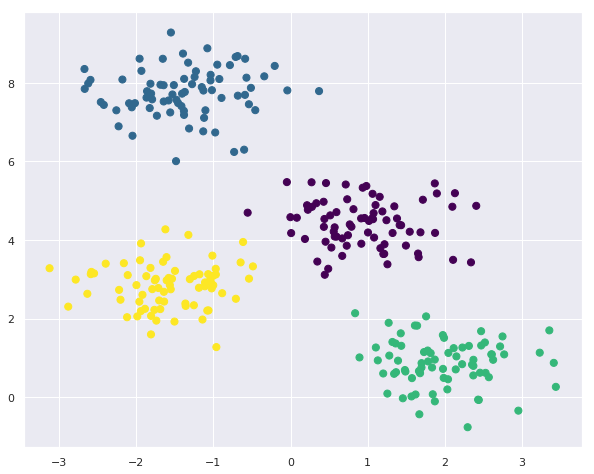

In [23]:
centers, labels = find_clusters(X, 4)
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

## 期待値最大化法の注意点

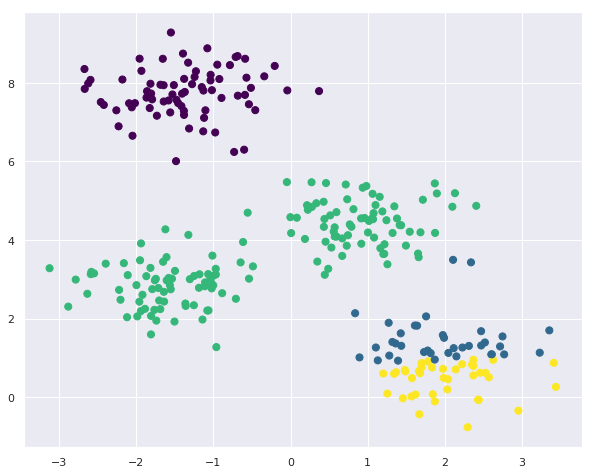

In [32]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

### クラスタ数をあらかじめ設定する必要がある

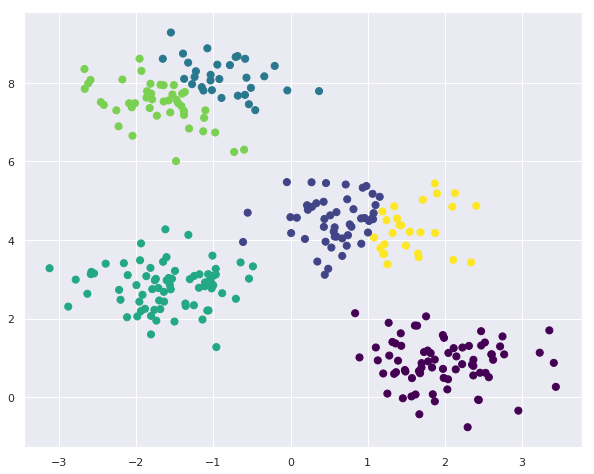

In [34]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

### k-meansは線形クラスタ境界に限定される

In [35]:
from sklearn.datasets import make_moons

In [38]:
X, y = make_moons(200, noise=.05, random_state=0)

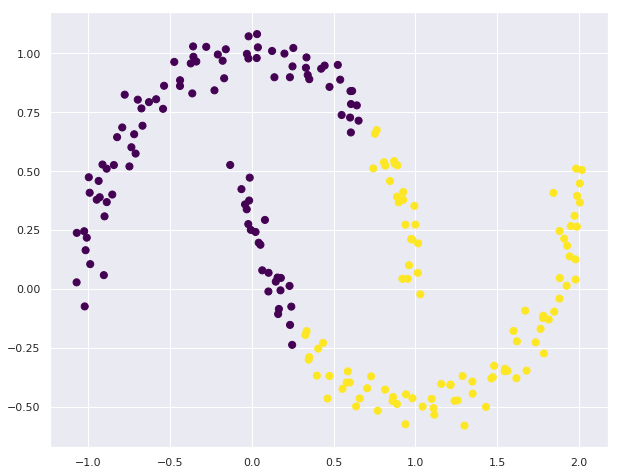

In [39]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

In [40]:
from sklearn.cluster import SpectralClustering

/Users/shimizukousuke/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


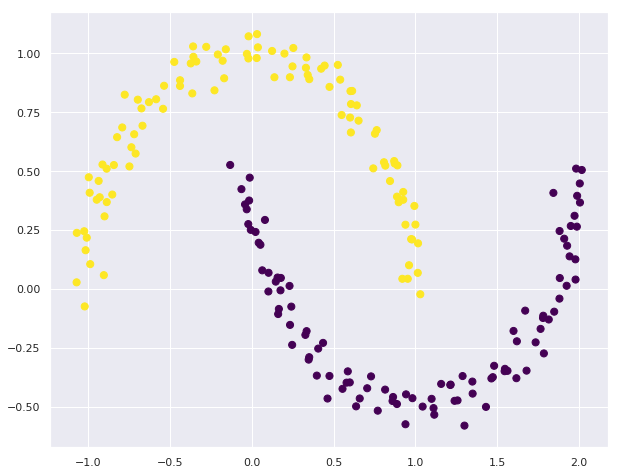

In [41]:
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
labels = model.fit_predict(X)
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

## 事例1:手書き数字

In [42]:
from sklearn.datasets import load_digits

In [43]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [44]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)